In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone

plt.style.use('ggplot')
plt.rcParams["savefig.format"] = 'svg'
plt.rcParams['image.cmap'] = 'viridis'

np.random.seed(42)

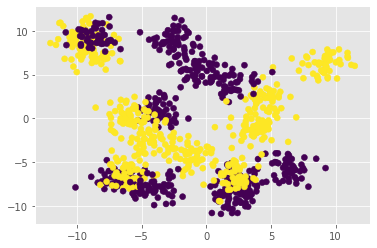

In [2]:
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier

n_samples=1000
n_features=2
centers=20
x, blob_id = make_blobs(n_samples=n_samples, n_features=n_features,
                        centers=centers, shuffle=False)
y = blob_id%2
plt.scatter(x[:, 0], x[:, 1], c=y)

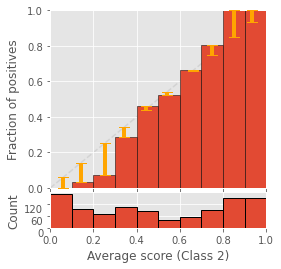

In [3]:
from sklearn.linear_model import LogisticRegression
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(x, y)

scores = clf.predict_proba(x)[:, 1]

from pycalib.visualisations import plot_reliability_diagram

plot_reliability_diagram(y, np.vstack([1 - scores, scores]).T,
                         show_bars=True, show_gaps=True,
                         color_gaps='orange');

In [4]:
class PAV(object):
    def __init__(self):
        pass
    
    def fit(self, scores, y):
        """
        Parameters
        ==========
        scores: array of floats (n_samples)
            Probability of positive class
        y: array of integers (n_samples)
            With ones for positive class and zero for negative
        """
        sorted_idx = np.argsort(scores)
        f = np.copy(scores[sorted_idx])
        m = np.copy(y[sorted_idx]).astype('float')
        w = np.ones_like(y).astype('float')
        decreasing_mask = (m[:-1] - m[1:]) > 0
        while np.any(decreasing_mask):
            first_idx = np.where(decreasing_mask)[0][0]
            new_w = w[first_idx] + w[first_idx+1]
            new_m = (m[first_idx]*w[first_idx] + m[first_idx+1]*w[first_idx+1])/new_w
            m[first_idx] = new_m
            w[first_idx] = new_w
            w = np.delete(w, first_idx+1)
            m = np.delete(m, first_idx+1)
            decreasing_mask = (m[:-1] - m[1:]) > 0
        w = np.concatenate([[0], w, [1]])
        m = np.concatenate([[m[0]], m, [m[-1]]])
        f = np.concatenate([[0], f, [1]])
        self.f = f[np.cumsum(w).astype(int)]
        self.m = m
        self.w = w
        
    def predict(self, scores):
        out = np.zeros_like(scores)
        for i, s in enumerate(scores):
            higher_mask = s <= self.f
            lower_idx = np.where(higher_mask)[0][0]
            out[i] = self.m[lower_idx]
        return out
        

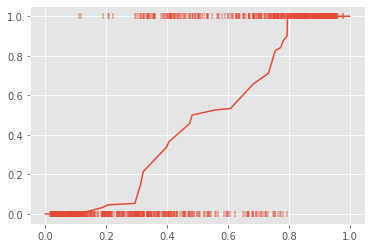

In [5]:
pav = PAV()
pav.fit(scores, y)
plt.plot(pav.f, pav.m)
plt.scatter(scores, y, marker='|', alpha=0.5)

In [6]:
from sklearn.isotonic import IsotonicRegression

ir = IsotonicRegression(y_min=0, y_max=1)
ir.fit(scores, y)

IsotonicRegression(y_max=1, y_min=0)

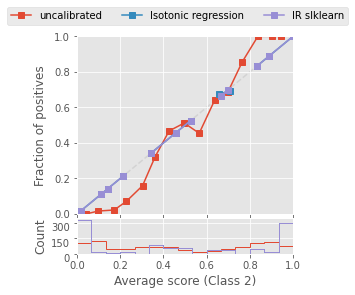

In [7]:
scores_cal = pav.predict(scores)
scores_cal_sklearn = ir.predict(scores)
plot_reliability_diagram(y, [np.vstack([1 - scores, scores]).T,
                             np.vstack([1 - scores_cal, scores_cal]).T,
                             np.vstack([1 - scores_cal_sklearn, scores_cal_sklearn]).T,
                             ],
                         legend=['uncalibrated', 'Isotonic regression',
                                 'IR slklearn'], bins=15);

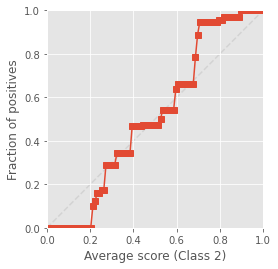

In [8]:
from pycalib.visualisations import plot_reliability_diagram_precomputed

scores = np.linspace(0, 1, 100)
scores_cal = pav.predict(1 - scores)
plot_reliability_diagram_precomputed(np.vstack([1 - scores_cal, scores_cal]).T,
                                     np.vstack([1 - scores, scores]).T);